In [1]:
import pandas as pd
import numpy as np

from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBClassifier, plot_importance
from matplotlib import pyplot as plt

# Feature Importance: Indicators of Wealth (US vs. World)

In [2]:
df = pd.read_csv(filepath_or_buffer='/kaggle/input/billionaires-statistics-dataset/Billionaires Statistics Dataset.csv')
df.drop(['date'], inplace=True, axis=1)
print("\nBillionaires in the world: ", len(df))

billionaires_by_country = df.groupby(['country'])['personName'].count().sort_values(ascending=False)
print("Countries with billionaires: ", len(billionaires_by_country))
print("\nAll Features: ", "\n", df.columns.values)


Billionaires in the world:  2640
Countries with billionaires:  78

All Features:  
 ['rank' 'finalWorth' 'category' 'personName' 'age' 'country' 'city'
 'source' 'industries' 'countryOfCitizenship' 'organization' 'selfMade'
 'status' 'gender' 'birthDate' 'lastName' 'firstName' 'title' 'state'
 'residenceStateRegion' 'birthYear' 'birthMonth' 'birthDay' 'cpi_country'
 'cpi_change_country' 'gdp_country' 'gross_tertiary_education_enrollment'
 'gross_primary_education_enrollment_country' 'life_expectancy_country'
 'tax_revenue_country_country' 'total_tax_rate_country'
 'population_country' 'latitude_country' 'longitude_country']


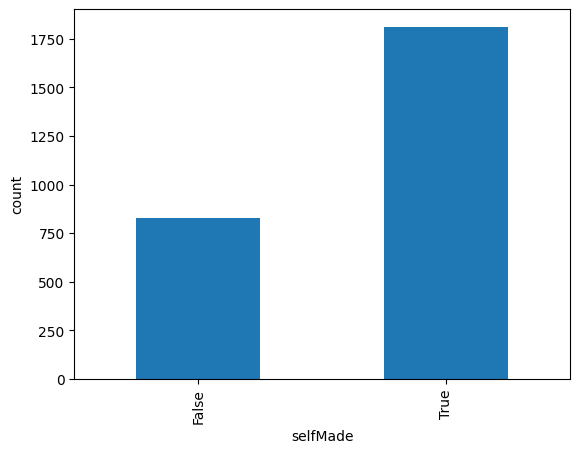

In [3]:
df.selfMade.value_counts().sort_index().plot.bar()
plt.ylabel('count');

In [4]:
print("Categorical Data Summary: ")
df.select_dtypes(['O', 'bool']).describe().T

Categorical Data Summary: 


,count,unique,top,freq
category,2640,18,Finance & Investments,372
personName,2640,2638,Wang Yanqing & family,2
country,2602,78,United States,754
city,2568,741,New York,99
source,2640,906,Real estate,151
industries,2640,18,Finance & Investments,372
countryOfCitizenship,2640,77,United States,735
organization,325,294,Meta Platforms,4
selfMade,2640,2,True,1812
status,2640,6,D,1223


In [5]:
print("Numerical Data Summary: ")
df.describe(percentiles=[]).T

Numerical Data Summary: 


,count,mean,std,min,50%,max
rank,2640.0,1.289159e+03,7.396937e+02,1.000000,1.312000e+03,2.540000e+03
finalWorth,2640.0,4.623788e+03,9.834241e+03,1000.000000,2.300000e+03,2.110000e+05
age,2575.0,6.514019e+01,1.325810e+01,18.000000,6.500000e+01,1.010000e+02
birthYear,2564.0,1.957183e+03,1.328252e+01,1921.000000,1.957000e+03,2.004000e+03
birthMonth,2564.0,5.740250e+00,3.710085e+00,1.000000,6.000000e+00,1.200000e+01
birthDay,2564.0,1.209984e+01,9.918876e+00,1.000000,1.100000e+01,3.100000e+01
cpi_country,2456.0,1.277552e+02,2.645295e+01,99.550000,1.172400e+02,2.885700e+02
cpi_change_country,2456.0,4.364169e+00,3.623763e+00,-1.900000,2.900000e+00,5.350000e+01
gross_tertiary_education_enrollment,2458.0,6.722567e+01,2.134343e+01,4.000000,6.560000e+01,1.366000e+02
gross_primary_education_enrollment_country,2459.0,1.028585e+02,4.710977e+00,84.700000,1.018000e+02,1.421000e+02


In [6]:
# Dropping columns not useful for analysis, or not worth encoding in model (too many categories, or missing values, are too similar to another row, etc.)
wealth_df = df.drop(["rank", "personName", "organization", "status", "source", "birthDate", "birthYear", "firstName", "lastName", "category", "countryOfCitizenship",
                    "longitude_country", "latitude_country", "birthMonth", "birthDay", "city", "state", "residenceStateRegion", "title"], axis=1)
wealth_df['gdp_country'] = wealth_df['gdp_country'].str.replace('$','').replace(',','', regex=True).astype(float)

print("Numerical Features:")
numerical_features = wealth_df.describe(include=np.number).columns.values
print(numerical_features)

print("\nCategorical Features:")
categorical_features = wealth_df.describe(include=['O']).columns.values
print(categorical_features)

Numerical Features:
['finalWorth' 'age' 'cpi_country' 'cpi_change_country' 'gdp_country'
 'gross_tertiary_education_enrollment'
 'gross_primary_education_enrollment_country' 'life_expectancy_country'
 'tax_revenue_country_country' 'total_tax_rate_country'
 'population_country']

Categorical Features:
['country' 'industries' 'gender']


In [7]:
wealth_df['industries'].unique()

array(['Fashion & Retail', 'Automotive', 'Technology',
       'Finance & Investments', 'Media & Entertainment', 'Telecom',
       'Diversified', 'Food & Beverage', 'Logistics',
       'Gambling & Casinos', 'Manufacturing', 'Real Estate',
       'Metals & Mining', 'Energy', 'Healthcare', 'Service',
       'Construction & Engineering', 'Sports'], dtype=object)

In [8]:
print(wealth_df.isna().sum())

finalWorth                                      0
age                                            65
country                                        38
industries                                      0
selfMade                                        0
gender                                          0
cpi_country                                   184
cpi_change_country                            184
gdp_country                                   164
gross_tertiary_education_enrollment           182
gross_primary_education_enrollment_country    181
life_expectancy_country                       182
tax_revenue_country_country                   183
total_tax_rate_country                        182
population_country                            164
dtype: int64


In [9]:
x = wealth_df.drop(columns=["selfMade"])
y = wealth_df.selfMade

# Normalize/scale data
transformer = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(), categorical_features), sparse_threshold=0)
transformed_data = transformer.fit_transform(x)

feature_names = [name.split("__")[-1] for name in transformer.get_feature_names_out()]
X = pd.DataFrame(transformed_data, columns=feature_names).drop(columns=['country_nan'])

print("# Features: {0}".format(len(X.columns)))

print("\nSelf made: ", len(wealth_df[wealth_df.selfMade == 1]))
print("Inherited: ", len(wealth_df[wealth_df.selfMade == 0]))

# Features: 109

Self made:  1812
Inherited:  828


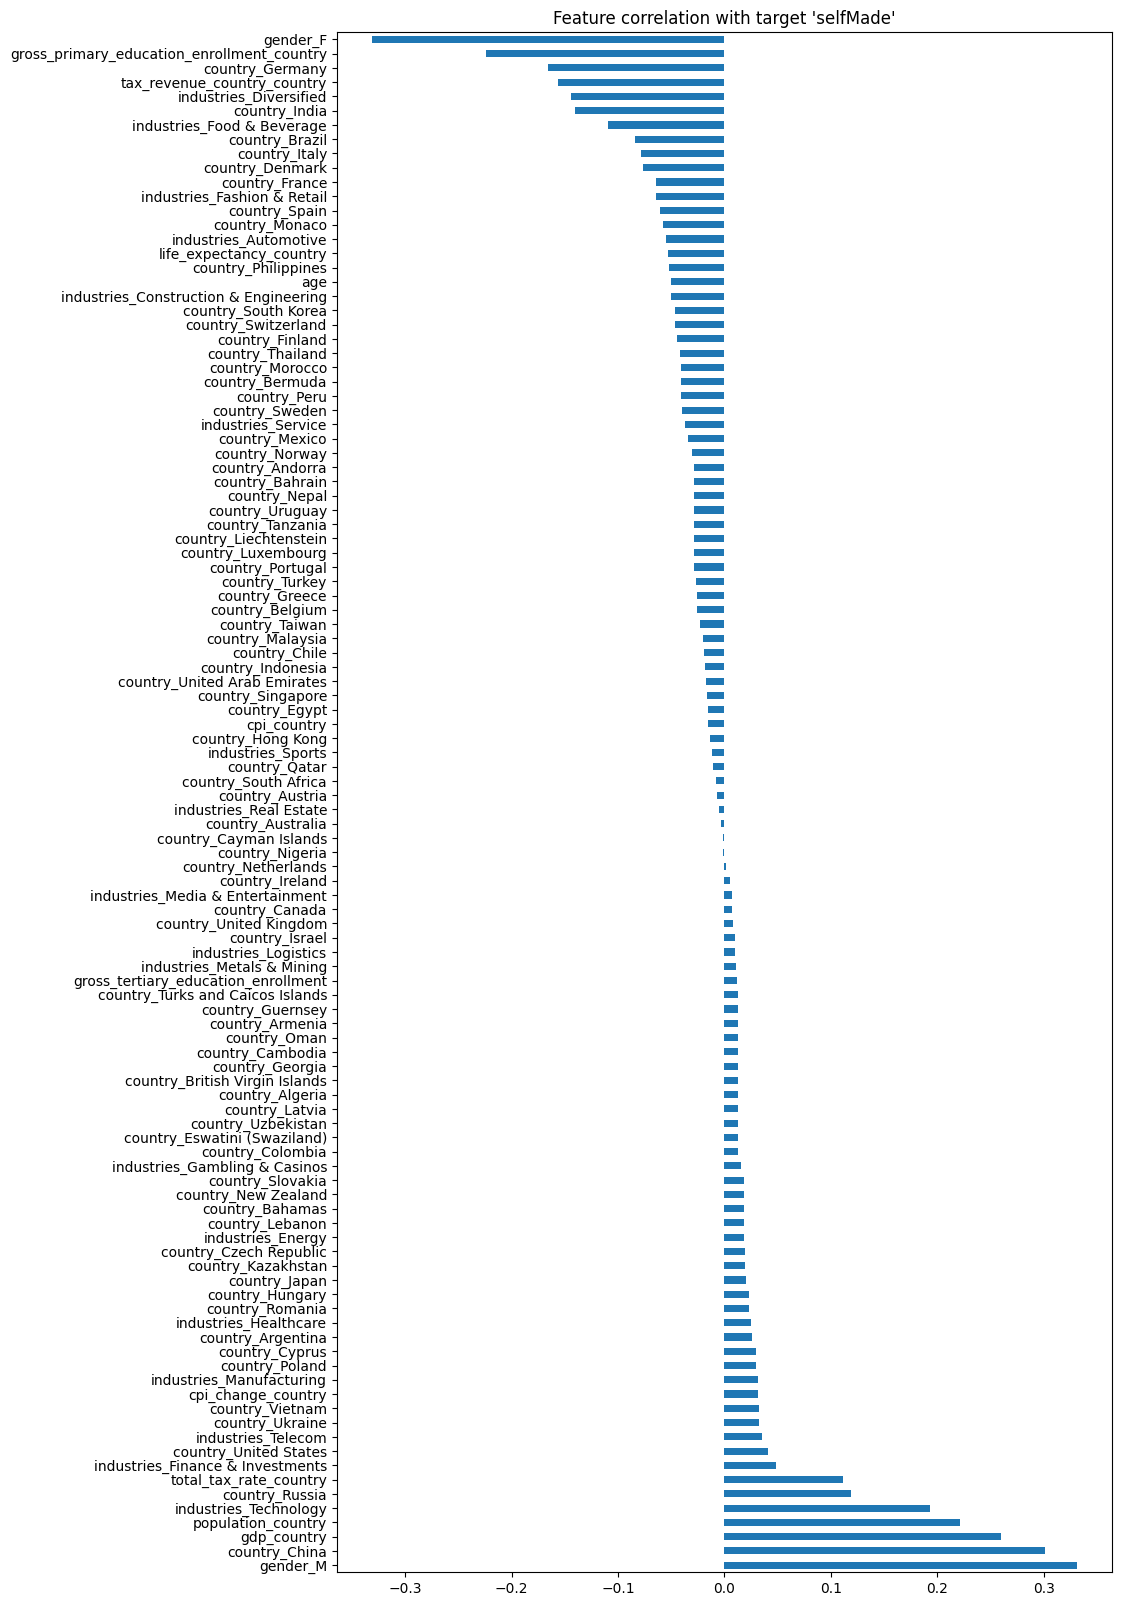

In [10]:
corr_data = X.join(y)
corr_matrix = corr_data[corr_data.columns[1:]].corr()['selfMade'][:].sort_values(ascending=False)
corr_matrix.drop('selfMade', inplace=True)

corr_matrix.plot(title="Feature correlation with target 'selfMade'", kind='barh', figsize=(10, 20))
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Training set size: ", len(X_train))
print("Testing set size: ", len(X_test))

Training set size:  1980
Testing set size:  660


In [12]:
clf = XGBClassifier(objective='binary:logistic', 
                    eval_metric='auc',
                    validate_parameters=True,
                    random_state = 42, n_jobs = -1)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("ROC AUC scores:")
print("Train: %.2f%%" % (round(roc_auc_score(y_train, y_train_pred) * 100, 2)))
print("Test: %.2f%%" % (round(roc_auc_score(y_test, y_pred) * 100, 2)))

ROC AUC scores:
Train: 96.45%
Test: 73.44%


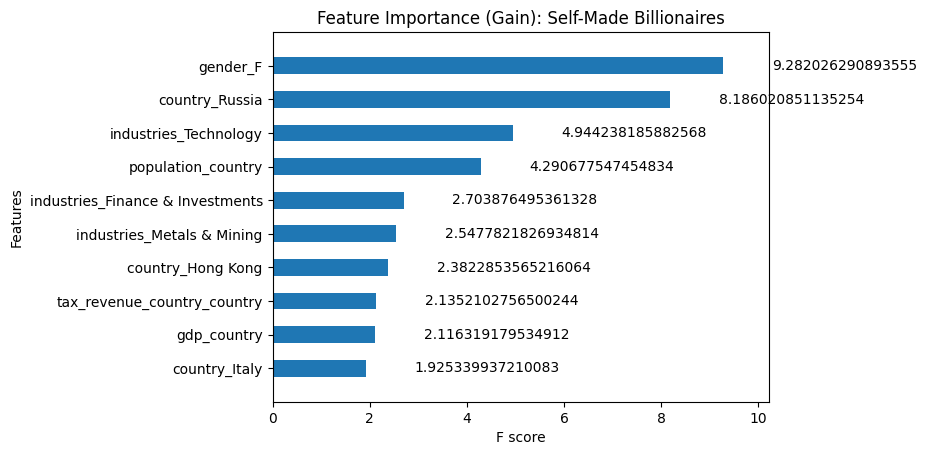

In [13]:
plot_importance(clf, max_num_features=10, 
                grid=False, 
                height=.5,
                importance_type='gain',
                title="Feature Importance (Gain): Self-Made Billionaires")
plt.show()

In [14]:
self_made = wealth_df.selfMade.value_counts()
gs_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'scale_pos_weight': [self_made[0]/self_made[1]],
}

cv_clf = GridSearchCV(estimator=clf, 
                      scoring='roc_auc', 
                      param_grid=gs_params, 
                      return_train_score=True,
                      refit=True,
                      n_jobs=-1)
cv_clf.fit(X_train, y_train)

best_params = cv_clf.best_params_
print("Best set of hyperparameters: ", best_params)
print("AUC-ROC score: %.2f%%" % round(cv_clf.best_score_ * 100, 2))

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 7, 'scale_pos_weight': 2.1884057971014492, 'subsample': 0.7}
AUC-ROC score: 82.62%


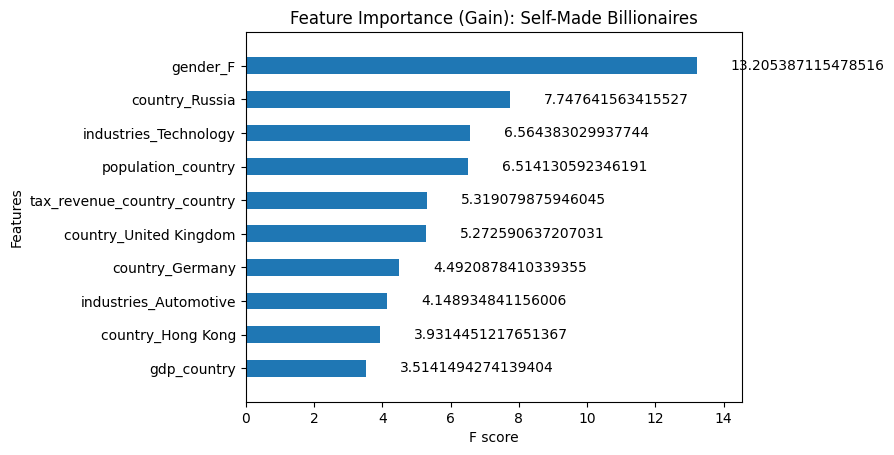

In [15]:
plot_importance(cv_clf.best_estimator_, max_num_features=10, 
                grid=False, 
                height=.5,
                importance_type='gain',
                title="Feature Importance (Gain): Self-Made Billionaires")
plt.show()

<!-- https://www.aitimejournal.com/intro-to-classification-and-feature-selection-with-xgboost/2778/ -->